# One-Max Problem

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/google/pyglove/blob/main/docs/notebooks/evolution/onemax.ipynb)


One-Max is a simple problem often used to introduce the concept of genetic algorithms. The problem boils down to one question: **what is the maximum sum of a bitstring (a string consisting of only 1s and 0s) of length N?**

This tutorial will show how this problem can be solved in PyGlove's way, with an option to use user-defined genome encoding.

*(Disclaimer: PyGlove is designed to be used with problems with evaluation time greater than sub-second, since the onemax problem can be evaluated in nano/micro-seconds, you may find slowdown in PyGlove's solution. Bear in mind that the overhead from PyGlove for each iteration is in sub-seconds)*

In [ ]:
!pip install pyglove

## Solving One-Max with `pg.oneof`

First we show that the search space can be expressed with `pg.oneof`, a PyGlove's built-in primitive for search space specification.

Best sequence: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1] (sum=10)


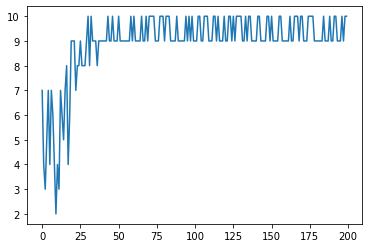

In [ ]:
import pyglove as pg
import matplotlib.pyplot as plt

def one_max(search_space, search_algorithm, num_trials=200) -> None:
  best_sequence, best_reward = None, None
  history = []
  for sequence, feedback in pg.sample(
      search_space, search_algorithm,
      num_examples=num_trials):
    reward = sum(sequence)
    if best_reward is None or best_reward < reward:
      best_sequence, best_reward = sequence, reward
    feedback(reward)
    history.append(reward)
  print(f'Best sequence: {list(best_sequence)} (sum={best_reward})')
  plt.plot(list(range(num_trials)), history)
  plt.show()

N = 10
search_space = pg.List([pg.oneof([0, 1])] * N)
search_algorithm = pg.evolution.regularized_evolution(
    population_size=20, tournament_size=10)

one_max(search_space, search_algorithm)

## Solving the same problem with custom genome encoding

At times, users might want to encode the search space without using PyGlove's built-in search primitives, when they have a more efficient genome representation, or to support new semantics of the search space (e.g. variable number of decision points). In such cases, PyGlove allows the user to define their own search primitives by extending `pg.hyper.CustomHyper`. The user needs to implement `custom_decode` method, which takes a `pg.DNA` with string value and returns its corresponding client object for evaluation. In this case, the client object is a list of binary integers. 

The user needs to also implement a mutator for such custom-encoded DNA, and provides a DNA generator for generating the initial population. The custom mutator can be combined with PyGlove's built-in evolution operations to create new algorithms. 

Best sequence: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1] (sum=10)


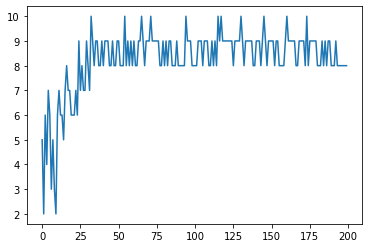

In [ ]:
import random

class BitString(pg.hyper.CustomHyper):

  def custom_decode(self, dna: pg.DNA):
    assert isinstance(dna.value, str)
    bitstr = dna.value
    return [int(x) for x in bitstr]

class MutateOneBit(pg.evolution.Mutator):

  def mutate(self, dna: pg.DNA):
    bitstr = dna.value
    assert len(bitstr) > 0
    index = random.randint(0, len(dna.value) - 1)
    new_bitstr = (bitstr[:index]
        + ('0' if bitstr[index] == '1' else '1')
        + bitstr[index + 1:])
    return pg.DNA(new_bitstr)

def init_population(population_size, n):
  @pg.geno.dna_generator
  def initializer(dna_spec):
    for _ in range(population_size):
      bits = [str(random.randint(0, 1)) for _ in range(n)]
      yield pg.DNA(''.join(bits))
  return initializer()
  
search_space = BitString()
search_algorithm = pg.evolution.Evolution(
    (pg.evolution.selectors.Random(10)
     >> pg.evolution.selectors.Top(1)
     >> MutateOneBit()),
    population_init=init_population(10, N),
    population_update=pg.evolution.selectors.Last(20))

one_max(search_space, search_algorithm)